In [1]:
import matplotlib.pyplot as plt
import pandas as pd
from sqlalchemy import create_engine
import seaborn as sns
import sklearn

#建立與 MySQL 的連結
class mysql_engine():
 def __init__(self,db):
  self.user='root'
  self.passwd=''
  self.host='localhost'
  self.port = '3306'
  self.db_name= db
  self.engine = create_engine('mysql+pymysql://{0}:{1}@{2}:{3}/{4}?charset=utf8'.format(self.user,self.passwd,self.host,self.port,self.db_name))

def get_data(sql,db):
 pg_enine = mysql_engine(db)
 try:
  with pg_enine.engine.connect() as con, con.begin():
   df = pd.read_sql(sql,con) # 獲取資料
  con.close()
 except:
  df = None
 return df

In [2]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.metrics import accuracy_score
from sklearn.metrics import confusion_matrix

# 取 X值 (20183-20211)

In [3]:
company_factor = get_data("""SELECT 
                            operating_gross_rate,
                            net_profit_rate,
                            revenue_growth_rate,
                            current_rate, 
                            quick_rate,  
                            debt_rate,  
                            receivables_turnover_rate, 
                            debt_growth_rate,
                            cash_reinvest_rate,
                            avg_director_rate, 
                            avg_director_pledge_rate, 
                            foreign_rate_bys, 
                            over1000_rate_bys, 
                            under400_rate_bys, 
                            avg_board_bys
                            FROM tfb103d_project.datamining_alldata_afetl
                            WHERE stock_report_date < '20212';""",'tfb103d_project')

company_factor

,operating_gross_rate,net_profit_rate,revenue_growth_rate,current_rate,quick_rate,debt_rate,receivables_turnover_rate,debt_growth_rate,cash_reinvest_rate,avg_director_rate,avg_director_pledge_rate,foreign_rate_bys,over1000_rate_bys,under400_rate_bys,avg_board_bys
0,38.03,13.35,17.77,154.53,103.70,18.22,3.31,1.22,1.74,26.60,0.00,4.40,62.23,33.99,8.73
1,40.93,5.22,-0.91,166.92,110.41,16.86,4.35,-5.28,1.34,26.60,0.00,4.40,62.35,34.08,8.86
2,37.03,-3.00,-6.33,171.94,109.89,16.38,0.99,-14.95,1.51,26.60,0.00,4.37,62.53,33.68,8.90
3,32.10,10.26,-2.46,174.72,114.79,16.63,2.00,-17.02,2.17,26.60,0.00,4.30,62.34,33.51,9.01
4,28.78,2.29,-6.54,170.04,116.92,17.45,3.10,-4.23,4.32,26.60,0.00,4.30,62.33,33.44,9.11
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1634,30.43,14.75,37.71,326.95,199.20,25.75,1.99,-10.18,-0.03,17.70,12.77,56.57,45.83,38.01,10.07
1635,24.76,10.91,10.95,299.48,181.73,27.74,4.28,-10.08,6.49,17.70,12.73,51.13,41.64,44.76,7.51
1636,22.61,15.41,-3.71,363.99,240.63,23.66,6.20,6.96,5.25,18.23,17.90,45.53,37.24,51.68,6.58
1637,23.05,29.47,-2.52,317.33,230.20,26.09,8.12,6.71,11.28,18.40,17.80,47.07,36.67,51.03,6.80


# 取 Y值 (20184-20212)

In [4]:
Roe_rul = get_data("""SELECT roe_rate
                      FROM tfb103d_project.datamining_alldata_afetl
                      WHERE stock_report_date > '20183';""",'tfb103d_project')
Roe_rul

,roe_rate
0,0.42
1,-0.20
2,0.85
3,0.17
4,-0.80
...,...
1634,4.01
1635,6.07
1636,11.76
1637,4.71


<h1>資料前處理

In [5]:
#缺值檢視
company_factor.isnull().sum()

operating_gross_rate         0
net_profit_rate              0
revenue_growth_rate          0
current_rate                 0
quick_rate                   0
debt_rate                    0
receivables_turnover_rate    0
debt_growth_rate             0
cash_reinvest_rate           0
avg_director_rate            0
avg_director_pledge_rate     0
foreign_rate_bys             0
over1000_rate_bys            0
under400_rate_bys            0
avg_board_bys                0
dtype: int64

In [6]:
Roe_rul.isnull().sum()

roe_rate    0
dtype: int64

In [7]:
# 將數值轉為 1,0 編碼，作為模型的預測目標(應變數)
def encoding(r,th):
    if r >= th:
        return 1
    else:
        return 0

In [8]:
#定義股東權益報酬率 >平均者為表現良好
m2 = Roe_rul['roe_rate'].mean()
Roe_rul['roe_rate1'] = Roe_rul.apply(lambda r : encoding(r['roe_rate'],m2), axis = 1)

In [9]:
X = company_factor

y = Roe_rul['roe_rate1']

print("x.shape: " ,X.shape)
print("y.shape: " ,y.shape)
print('y:',y.value_counts(normalize = True))

x.shape:  (1639, 15)
y.shape:  (1639,)
y: 1    0.539353
0    0.460647
Name: roe_rate1, dtype: float64


<h3> ROE:  755 筆標記為 0 ； 884 筆為 1
<h3> 基準準確度(空準確度) 為 53.93%

## 假設檢定

<h4>H0 (虛無假設): 特徵與應變量 (y) 沒有關係
<h4>針對每個特徵進行檢定，判定是否有顯著關係

<h3> 建立 篩選器 與 篩選方式
<h3> 篩選方式可用 f_classif, chi2

In [10]:
from sklearn.feature_selection import SelectKBest, f_classif

In [11]:
k_best = SelectKBest(f_classif, k =5)
k_best.fit_transform(X,y)

array([[38.03, 13.35, 17.77,  1.74,  4.4 ],
       [40.93,  5.22, -0.91,  1.34,  4.4 ],
       [37.03, -3.  , -6.33,  1.51,  4.37],
       ...,
       [22.61, 15.41, -3.71,  5.25, 45.53],
       [23.05, 29.47, -2.52, 11.28, 47.07],
       [29.71, 13.09,  0.17, -3.7 , 48.57]])

<h3> 通常 P-value < 0.05 即可證明兩者有關聯，而拒絕 H0

In [12]:
p_values = pd.DataFrame({"Column":X.columns,"P-value":k_best.pvalues_}).sort_values("P-value")
p_values[p_values["P-value"]<0.01]

,Column,P-value
8,cash_reinvest_rate,2.651661e-30
11,foreign_rate_bys,2.127576e-28
2,revenue_growth_rate,3.575869e-27
1,net_profit_rate,3.359445e-25
0,operating_gross_rate,1.492286e-19
3,current_rate,6.968062e-15
4,quick_rate,6.627992e-13
14,avg_board_bys,4.403513e-08
13,under400_rate_bys,2.708657e-05
5,debt_rate,5.878679e-05


In [13]:
high_corr = p_values[p_values["P-value"]<0.01].iloc[:,0]
high_corr

8       cash_reinvest_rate
11        foreign_rate_bys
2      revenue_growth_rate
1          net_profit_rate
0     operating_gross_rate
3             current_rate
4               quick_rate
14           avg_board_bys
13       under400_rate_bys
5                debt_rate
Name: Column, dtype: object

<h3>篩選出有顯著關係的特徵加入為 X

In [14]:
X_sel = X[high_corr]
X_sel

,cash_reinvest_rate,foreign_rate_bys,revenue_growth_rate,net_profit_rate,operating_gross_rate,current_rate,quick_rate,avg_board_bys,under400_rate_bys,debt_rate
0,1.74,4.40,17.77,13.35,38.03,154.53,103.70,8.73,33.99,18.22
1,1.34,4.40,-0.91,5.22,40.93,166.92,110.41,8.86,34.08,16.86
2,1.51,4.37,-6.33,-3.00,37.03,171.94,109.89,8.90,33.68,16.38
3,2.17,4.30,-2.46,10.26,32.10,174.72,114.79,9.01,33.51,16.63
4,4.32,4.30,-6.54,2.29,28.78,170.04,116.92,9.11,33.44,17.45
...,...,...,...,...,...,...,...,...,...,...
1634,-0.03,56.57,37.71,14.75,30.43,326.95,199.20,10.07,38.01,25.75
1635,6.49,51.13,10.95,10.91,24.76,299.48,181.73,7.51,44.76,27.74
1636,5.25,45.53,-3.71,15.41,22.61,363.99,240.63,6.58,51.68,23.66
1637,11.28,47.07,-2.52,29.47,23.05,317.33,230.20,6.80,51.03,26.09


In [15]:
# 輸入數據調成標準值以免各特徵影響不同
from sklearn.preprocessing import StandardScaler
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X_sel)

In [16]:
#分割資料為 測試集 與 訓練集
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X_scaled, y, test_size=0.2,random_state=1)
N, D = X_train.shape
print ("N:", N, "D:", D)

N: 1311 D: 10


# 1. 以財務數據預測 ROE

In [29]:
import numpy as np
import matplotlib.pyplot as plt
from tensorflow.keras.layers import Input, Conv2D, Dense, Flatten, Dropout,LeakyReLU
from tensorflow.keras.models import Model
from sklearn.metrics import accuracy_score
from sklearn.metrics import confusion_matrix
import tensorflow as tf
print(tf.__version__)

2.6.0


In [292]:
# 建立TF模型 for 淨利
model = tf.keras.models.Sequential([
  tf.keras.layers.Input(shape=(D,)),
  tf.keras.layers.Dense(128, activation='relu'),
  tf.keras.layers.Dropout(0.4),
  tf.keras.layers.Dense(16, activation='relu'),
  tf.keras.layers.Dropout(0.2),
  tf.keras.layers.Dense(1, activation='sigmoid')
  ])

#編譯模型
lr = 0.0003
model.compile(tf.keras.optimizers.Adam(learning_rate = lr),
              loss='binary_crossentropy',
              metrics=['accuracy'])

In [293]:
model.summary()

Model: "sequential_21"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_63 (Dense)             (None, 128)               1408      
_________________________________________________________________
dropout_42 (Dropout)         (None, 128)               0         
_________________________________________________________________
dense_64 (Dense)             (None, 16)                2064      
_________________________________________________________________
dropout_43 (Dropout)         (None, 16)                0         
_________________________________________________________________
dense_65 (Dense)             (None, 1)                 17        
Total params: 3,489
Trainable params: 3,489
Non-trainable params: 0
_________________________________________________________________


In [294]:
# 訓練模型
r = model.fit(X_train, y_train, validation_data=(X_test, y_test), epochs=100)

# 評估模型 - evaluate() returns loss and accuracy
print("Train score:", model.evaluate(X_train, y_train))
print("Test score:", model.evaluate(X_test, y_test))

Epoch 1/100
41/41 [==============================] - 0s 4ms/step - loss: 0.7117 - accuracy: 0.5347 - val_loss: 0.6658 - val_accuracy: 0.6494
Epoch 2/100
41/41 [==============================] - 0s 2ms/step - loss: 0.6621 - accuracy: 0.6095 - val_loss: 0.6289 - val_accuracy: 0.6951
Epoch 3/100
41/41 [==============================] - 0s 1ms/step - loss: 0.6306 - accuracy: 0.6568 - val_loss: 0.6009 - val_accuracy: 0.6982
Epoch 4/100
41/41 [==============================] - 0s 1ms/step - loss: 0.6071 - accuracy: 0.6865 - val_loss: 0.5788 - val_accuracy: 0.7226
Epoch 5/100
41/41 [==============================] - 0s 1ms/step - loss: 0.5838 - accuracy: 0.7094 - val_loss: 0.5607 - val_accuracy: 0.7287
Epoch 6/100
41/41 [==============================] - 0s 1ms/step - loss: 0.5770 - accuracy: 0.7155 - val_loss: 0.5469 - val_accuracy: 0.7409
Epoch 7/100
41/41 [==============================] - 0s 1ms/step - loss: 0.5622 - accuracy: 0.7338 - val_loss: 0.5365 - val_accuracy: 0.7317
Epoch 8/100
4

Epoch 59/100
41/41 [==============================] - 0s 1ms/step - loss: 0.4569 - accuracy: 0.7834 - val_loss: 0.4718 - val_accuracy: 0.7744
Epoch 60/100
41/41 [==============================] - 0s 1ms/step - loss: 0.4645 - accuracy: 0.7811 - val_loss: 0.4716 - val_accuracy: 0.7774
Epoch 61/100
41/41 [==============================] - 0s 1ms/step - loss: 0.4640 - accuracy: 0.7902 - val_loss: 0.4700 - val_accuracy: 0.7683
Epoch 62/100
41/41 [==============================] - 0s 1ms/step - loss: 0.4684 - accuracy: 0.7864 - val_loss: 0.4700 - val_accuracy: 0.7744
Epoch 63/100
41/41 [==============================] - 0s 1ms/step - loss: 0.4679 - accuracy: 0.7818 - val_loss: 0.4704 - val_accuracy: 0.7774
Epoch 64/100
41/41 [==============================] - 0s 1ms/step - loss: 0.4641 - accuracy: 0.7864 - val_loss: 0.4711 - val_accuracy: 0.7744
Epoch 65/100
41/41 [==============================] - 0s 1ms/step - loss: 0.4612 - accuracy: 0.7872 - val_loss: 0.4707 - val_accuracy: 0.7744
Epoch 

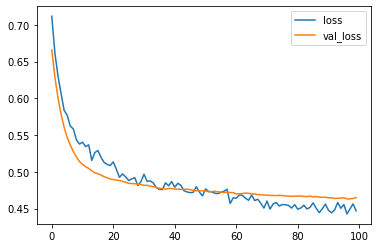

In [295]:
# 劃出 model.fit() training 和 validating 的 loss
import matplotlib.pyplot as plt
plt.plot(r.history['loss'], label='loss')
plt.plot(r.history['val_loss'], label='val_loss')
plt.legend()

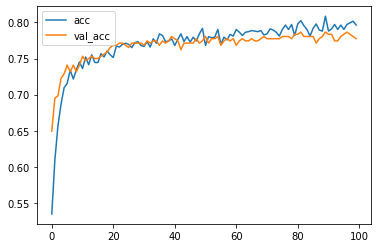

In [296]:
# 劃出準確性 accuracy 
plt.plot(r.history['accuracy'], label='acc')
plt.plot(r.history['val_accuracy'], label='val_acc')
plt.legend()

In [297]:
pred_test = model.predict(X_test)
pred_test = np.round(pred_test).flatten()
cm = confusion_matrix(y_test, pred_test)
cm

array([[105,  43],
       [ 30, 150]], dtype=int64)

# 2.加入進口環境因素預測 ROE

<h2>資料前處理

In [46]:
#取得需要的特徵
addenv_factor = get_data("""SELECT 
                            operating_gross_rate,
                            net_profit_rate,
                            revenue_growth_rate,
                            current_rate, 
                            quick_rate,  
                            debt_rate,  
                            receivables_turnover_rate, 
                            debt_growth_rate,
                            cash_reinvest_rate,
                            avg_director_rate, 
                            avg_director_pledge_rate, 
                            foreign_rate_bys, 
                            over1000_rate_bys, 
                            under400_rate_bys, 
                            avg_board_bys
                            import_kgm_weight_2801, 
                            import_kgm_weight_2804, 
                            import_kgm_weight_37071000,
                            import_kgm_weight_37079090,
                            import_kgm_weight_37050000306,
                            import_kgm_weight_848620,
                            import_kgm_weight_848610,
                            import_kgm_weight_381800,
                            import_usd_value_2801,
                            import_usd_value_2804,
                            import_usd_value_37071000,
                            import_usd_value_37079090,
                            import_usd_value_37050000306,
                            import_usd_value_848620,
                            import_usd_value_848610,
                            import_usd_value_381800,
                            avg_import_rate
                            FROM tfb103d_project.datamining_alldata_afetl
                            WHERE stock_report_date < '20212';""",'tfb103d_project')
addenv_factor

,operating_gross_rate,net_profit_rate,revenue_growth_rate,current_rate,quick_rate,debt_rate,receivables_turnover_rate,debt_growth_rate,cash_reinvest_rate,avg_director_rate,...,import_kgm_weight_381800,import_usd_value_2801,import_usd_value_2804,import_usd_value_37071000,import_usd_value_37079090,import_usd_value_37050000306,import_usd_value_848620,import_usd_value_848610,import_usd_value_381800,avg_import_rate
0,38.03,13.35,17.77,154.53,103.70,18.22,3.31,1.22,1.74,26.60,...,1409793,862,46597,2987,54333,27410,675685,44346,242172,30.719
1,40.93,5.22,-0.91,166.92,110.41,16.86,4.35,-5.28,1.34,26.60,...,1053753,834,48412,498,59877,20281,519909,30940,228487,30.901
2,37.03,-3.00,-6.33,171.94,109.89,16.38,0.99,-14.95,1.51,26.60,...,1034009,732,39213,288,54298,20181,908995,51369,215901,30.880
3,32.10,10.26,-2.46,174.72,114.79,16.63,2.00,-17.02,2.17,26.60,...,898797,739,38985,934,58250,21878,744366,34141,218212,31.187
4,28.78,2.29,-6.54,170.04,116.92,17.45,3.10,-4.23,4.32,26.60,...,856956,680,30999,546,64807,25203,991427,24335,206041,31.248
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1634,30.43,14.75,37.71,326.95,199.20,25.75,1.99,-10.18,-0.03,17.70,...,851896,920,44500,419,69400,19159,877494,49017,219185,30.163
1635,24.76,10.91,10.95,299.48,181.73,27.74,4.28,-10.08,6.49,17.70,...,673790,777,34092,613,74795,21977,640466,26651,223348,29.941
1636,22.61,15.41,-3.71,363.99,240.63,23.66,6.20,6.96,5.25,18.23,...,693142,795,35919,201,73581,22766,854227,36716,213329,29.499
1637,23.05,29.47,-2.52,317.33,230.20,26.09,8.12,6.71,11.28,18.40,...,686162,847,41139,308,76867,23473,1333417,29918,226517,28.783


In [47]:
addenv_factor.isnull().sum()

operating_gross_rate             0
net_profit_rate                  0
revenue_growth_rate              0
current_rate                     0
quick_rate                       0
debt_rate                        0
receivables_turnover_rate        0
debt_growth_rate                 0
cash_reinvest_rate               0
avg_director_rate                0
avg_director_pledge_rate         0
foreign_rate_bys                 0
over1000_rate_bys                0
under400_rate_bys                0
import_kgm_weight_2801           0
import_kgm_weight_2804           0
import_kgm_weight_37071000       0
import_kgm_weight_37079090       0
import_kgm_weight_37050000306    0
import_kgm_weight_848620         0
import_kgm_weight_848610         0
import_kgm_weight_381800         0
import_usd_value_2801            0
import_usd_value_2804            0
import_usd_value_37071000        0
import_usd_value_37079090        0
import_usd_value_37050000306     0
import_usd_value_848620          0
import_usd_value_848

In [48]:
X1 = addenv_factor

y1 = Roe_rul['roe_rate1']
print("X1.shape: " ,X1.shape)
print("y1.shape: " ,y1.shape)
print('y1.sum():',y1.sum())

X1.shape:  (1639, 31)
y1.shape:  (1639,)
y1.sum(): 884


In [49]:
from sklearn.feature_selection import SelectKBest, f_classif

In [50]:
k_best1 = SelectKBest(f_classif, k =5)
k_best1.fit_transform(X1,y1)

array([[38.03, 13.35, 17.77,  1.74,  4.4 ],
       [40.93,  5.22, -0.91,  1.34,  4.4 ],
       [37.03, -3.  , -6.33,  1.51,  4.37],
       ...,
       [22.61, 15.41, -3.71,  5.25, 45.53],
       [23.05, 29.47, -2.52, 11.28, 47.07],
       [29.71, 13.09,  0.17, -3.7 , 48.57]])

In [52]:
p_values1 = pd.DataFrame({"Column":X1.columns,"P-value":k_best1.pvalues_}).sort_values("P-value")
p_values1[p_values1["P-value"]<0.01]

,Column,P-value
8,cash_reinvest_rate,2.651661e-30
11,foreign_rate_bys,2.127576e-28
2,revenue_growth_rate,3.575869e-27
1,net_profit_rate,3.359445e-25
0,operating_gross_rate,1.492286e-19
3,current_rate,6.968062e-15
4,quick_rate,6.627992e-13
30,avg_import_rate,4.121755e-12
14,import_kgm_weight_2801,4.403513e-08
16,import_kgm_weight_37071000,8.555021e-08


In [53]:
high_corr1 = p_values1[p_values1["P-value"]<0.01].iloc[:,0]
high_corr1

8             cash_reinvest_rate
11              foreign_rate_bys
2            revenue_growth_rate
1                net_profit_rate
0           operating_gross_rate
3                   current_rate
4                     quick_rate
30               avg_import_rate
14        import_kgm_weight_2801
16    import_kgm_weight_37071000
25     import_usd_value_37079090
20      import_kgm_weight_848610
13             under400_rate_bys
5                      debt_rate
28       import_usd_value_848610
21      import_kgm_weight_381800
22         import_usd_value_2801
29       import_usd_value_381800
Name: Column, dtype: object

In [54]:
X1_sel = X1[high_corr1]
X1_sel

,cash_reinvest_rate,foreign_rate_bys,revenue_growth_rate,net_profit_rate,operating_gross_rate,current_rate,quick_rate,avg_import_rate,import_kgm_weight_2801,import_kgm_weight_37071000,import_usd_value_37079090,import_kgm_weight_848610,under400_rate_bys,debt_rate,import_usd_value_848610,import_kgm_weight_381800,import_usd_value_2801,import_usd_value_381800
0,1.74,4.40,17.77,13.35,38.03,154.53,103.70,30.719,8.73,28033,54333,223993,33.99,18.22,44346,1409793,862,242172
1,1.34,4.40,-0.91,5.22,40.93,166.92,110.41,30.901,8.86,32577,59877,112522,34.08,16.86,30940,1053753,834,228487
2,1.51,4.37,-6.33,-3.00,37.03,171.94,109.89,30.880,8.90,20659,54298,185370,33.68,16.38,51369,1034009,732,215901
3,2.17,4.30,-2.46,10.26,32.10,174.72,114.79,31.187,9.01,28421,58250,210469,33.51,16.63,34141,898797,739,218212
4,4.32,4.30,-6.54,2.29,28.78,170.04,116.92,31.248,9.11,26078,64807,146841,33.44,17.45,24335,856956,680,206041
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1634,-0.03,56.57,37.71,14.75,30.43,326.95,199.20,30.163,10.07,23160,69400,248268,38.01,25.75,49017,851896,920,219185
1635,6.49,51.13,10.95,10.91,24.76,299.48,181.73,29.941,7.51,25065,74795,118859,44.76,27.74,26651,673790,777,223348
1636,5.25,45.53,-3.71,15.41,22.61,363.99,240.63,29.499,6.58,12327,73581,155479,51.68,23.66,36716,693142,795,213329
1637,11.28,47.07,-2.52,29.47,23.05,317.33,230.20,28.783,6.80,17648,76867,141336,51.03,26.09,29918,686162,847,226517


In [55]:
# 輸入數據調成標準值以免各特徵影響不同
# you'll learn why scaling is needed in a later course
# from sklearn.preprocessing import StandardScaler
def mean_norm(df_input):
    return df_input.apply(lambda x: ((x-df_input.mean())/ df_input.std()))

In [56]:
X1_scaled = pd.DataFrame()
a, b = X1_sel.shape

for i in range(b):
    x1_new = mean_norm(X1_sel[X1_sel.columns[i]])
    X1_scaled.insert(i,X1_sel.columns[i],x1_new)
    
X1_scaled

,cash_reinvest_rate,foreign_rate_bys,revenue_growth_rate,net_profit_rate,operating_gross_rate,current_rate,quick_rate,avg_import_rate,import_kgm_weight_2801,import_kgm_weight_37071000,import_usd_value_37079090,import_kgm_weight_848610,under400_rate_bys,debt_rate,import_usd_value_848610,import_kgm_weight_381800,import_usd_value_2801,import_usd_value_381800
0,-0.205327,-0.641917,0.195944,0.214147,0.310530,-0.553189,-0.513366,0.561617,-0.310411,0.838809,-1.496335,0.661580,-0.635222,-0.818028,0.501787,2.481341,0.582699,1.875001
1,-0.239816,-0.641917,-0.294623,0.060193,0.420361,-0.520781,-0.494960,0.761148,-0.301024,1.698021,-0.823357,-1.267097,-0.630684,-0.898471,-0.700685,0.844937,0.225897,0.603910
2,-0.225158,-0.643402,-0.436961,-0.095466,0.272657,-0.507650,-0.496387,0.738125,-0.298135,-0.555521,-1.500584,-0.006677,-0.650854,-0.926863,1.131726,0.754191,-1.073880,-0.565103
3,-0.168251,-0.646868,-0.335329,0.155633,0.085944,-0.500379,-0.482945,1.074696,-0.290191,0.912174,-1.020856,0.427587,-0.659426,-0.912075,-0.413566,0.132740,-0.984680,-0.350452
4,0.017126,-0.646868,-0.442476,0.004708,-0.039793,-0.512620,-0.477102,1.141572,-0.282970,0.469143,-0.224911,-0.673308,-0.662956,-0.863573,-1.293131,-0.059566,-1.736512,-1.480919
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1634,-0.357940,1.941256,0.719600,0.240658,0.022697,-0.102197,-0.251399,-0.047939,-0.213645,-0.082614,0.332627,1.081587,-0.432514,-0.372635,0.920759,-0.082823,1.321788,-0.260078
1635,0.204228,1.671897,0.016839,0.167942,-0.192042,-0.174049,-0.299321,-0.291323,-0.398512,0.277597,0.987518,-1.157454,-0.092144,-0.254929,-1.085393,-0.901420,-0.500449,0.126590
1636,0.097313,1.394616,-0.368156,0.253157,-0.273468,-0.005312,-0.137752,-0.775898,-0.465671,-2.130997,0.840153,-0.523853,0.256798,-0.496257,-0.182598,-0.812475,-0.271077,-0.803995
1637,0.617232,1.470868,-0.336905,0.519405,-0.256804,-0.127359,-0.166362,-1.560866,-0.449784,-1.124863,1.239036,-0.768555,0.224021,-0.352525,-0.792355,-0.844556,0.391555,0.420933


In [57]:
#分割資料為 測試集 與 訓練集
from sklearn.model_selection import train_test_split
X1_train, X1_test, y1_train, y1_test = train_test_split(X1_scaled, y1, test_size=0.2,random_state=1)
N, D = X1_train.shape
print ("N:", N, "D:", D)

N: 1311 D: 18


In [58]:
# 建立TF模型 for 淨利
model1 = tf.keras.models.Sequential([
  tf.keras.layers.Input(shape=(D,)),
  tf.keras.layers.Dense(128, activation='relu'),
  tf.keras.layers.Dropout(0.4),
  tf.keras.layers.Dense(16, activation='relu'),
  tf.keras.layers.Dropout(0.2),
  tf.keras.layers.Dense(1, activation='sigmoid')
  ])

#編譯模型
lr = 0.0003
model1.compile(tf.keras.optimizers.Adam(learning_rate = lr),
              loss='binary_crossentropy',
              metrics=['accuracy'])

In [59]:
model1.summary()

Model: "sequential_2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_6 (Dense)              (None, 128)               2432      
_________________________________________________________________
dropout_4 (Dropout)          (None, 128)               0         
_________________________________________________________________
dense_7 (Dense)              (None, 16)                2064      
_________________________________________________________________
dropout_5 (Dropout)          (None, 16)                0         
_________________________________________________________________
dense_8 (Dense)              (None, 1)                 17        
Total params: 4,513
Trainable params: 4,513
Non-trainable params: 0
_________________________________________________________________


In [63]:
# 訓練模型
r1 = model1.fit(X1_train, y1_train, validation_data=(X1_test, y1_test), epochs=150)

# 評估模型 - evaluate() returns loss and accuracy
print("Train score:", model1.evaluate(X1_train, y1_train))
print("Test score:", model1.evaluate(X1_test, y1_test))

Epoch 1/150
41/41 [==============================] - 0s 2ms/step - loss: 0.3896 - accuracy: 0.8207 - val_loss: 0.4759 - val_accuracy: 0.7744
Epoch 2/150
41/41 [==============================] - 0s 1ms/step - loss: 0.3772 - accuracy: 0.8383 - val_loss: 0.4786 - val_accuracy: 0.7774
Epoch 3/150
41/41 [==============================] - 0s 2ms/step - loss: 0.3896 - accuracy: 0.8261 - val_loss: 0.4773 - val_accuracy: 0.7744
Epoch 4/150
41/41 [==============================] - 0s 1ms/step - loss: 0.3956 - accuracy: 0.8375 - val_loss: 0.4759 - val_accuracy: 0.7744
Epoch 5/150
41/41 [==============================] - 0s 1ms/step - loss: 0.3835 - accuracy: 0.8268 - val_loss: 0.4773 - val_accuracy: 0.7744
Epoch 6/150
41/41 [==============================] - 0s 1ms/step - loss: 0.3944 - accuracy: 0.8268 - val_loss: 0.4758 - val_accuracy: 0.7744
Epoch 7/150
41/41 [==============================] - 0s 1ms/step - loss: 0.3926 - accuracy: 0.8253 - val_loss: 0.4761 - val_accuracy: 0.7744
Epoch 8/150
4

Epoch 59/150
41/41 [==============================] - 0s 2ms/step - loss: 0.3599 - accuracy: 0.8429 - val_loss: 0.4864 - val_accuracy: 0.7866
Epoch 60/150
41/41 [==============================] - 0s 2ms/step - loss: 0.3751 - accuracy: 0.8352 - val_loss: 0.4831 - val_accuracy: 0.7896
Epoch 61/150
41/41 [==============================] - 0s 2ms/step - loss: 0.3660 - accuracy: 0.8261 - val_loss: 0.4812 - val_accuracy: 0.7805
Epoch 62/150
41/41 [==============================] - 0s 2ms/step - loss: 0.3822 - accuracy: 0.8352 - val_loss: 0.4841 - val_accuracy: 0.7774
Epoch 63/150
41/41 [==============================] - 0s 2ms/step - loss: 0.3632 - accuracy: 0.8436 - val_loss: 0.4828 - val_accuracy: 0.7805
Epoch 64/150
41/41 [==============================] - 0s 2ms/step - loss: 0.3733 - accuracy: 0.8307 - val_loss: 0.4839 - val_accuracy: 0.7774
Epoch 65/150
41/41 [==============================] - 0s 2ms/step - loss: 0.3693 - accuracy: 0.8337 - val_loss: 0.4839 - val_accuracy: 0.7866
Epoch 

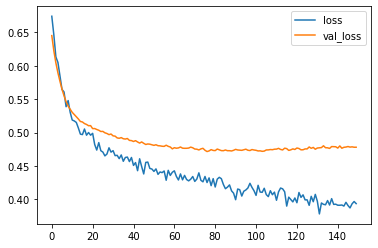

In [61]:
# 劃出 model.fit() training 和 validating 的 loss
import matplotlib.pyplot as plt
plt.plot(r1.history['loss'], label='loss')
plt.plot(r1.history['val_loss'], label='val_loss')
plt.legend()

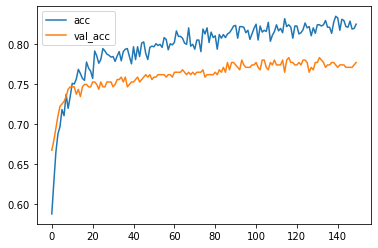

In [62]:
# 劃出準確性 accuracy 
plt.plot(r1.history['accuracy'], label='acc')
plt.plot(r1.history['val_accuracy'], label='val_acc')
plt.legend()

In [65]:
pred_test = model1.predict(X1_test)
pred_test = np.round(pred_test).flatten()
cm = confusion_matrix(y1_test, pred_test)
cm

array([[109,  39],
       [ 33, 147]], dtype=int64)

<H1>3. 加入全部環境因素 特徵篩選

In [17]:
#取得需要的特徵
addenv_factor2 = get_data("""SELECT *
                            FROM tfb103d_project.datamining_alldata_afetl
                            WHERE stock_report_date < '20212';""",'tfb103d_project')

addenv_factor2 = addenv_factor2.drop(['stock_code','stock_report_date'],axis=1)
addenv_factor2

,operating_gross_rate,net_profit_rate,revenue_growth_rate,current_rate,quick_rate,debt_rate,receivables_turnover_rate,cash_reinvest_rate,roe_rate,roa_rate,...,export_usd_value_37071000,export_usd_value_37079090,export_usd_value_37050000306,export_usd_value_848620,export_usd_value_848610,export_usd_value_381800,new_cases_smoothed_USA,new_cases_smoothed_OWID_EUR,new_cases_smoothed_TWN,people_fully_vaccinated_per_hundred_USA
0,38.03,13.35,17.77,154.53,103.70,18.22,3.31,1.74,1.07,0.91,...,433,15698,18323,61504,3021,107270,0.00,0.00,0.00,0.00
1,40.93,5.22,-0.91,166.92,110.41,16.86,4.35,1.34,0.42,0.37,...,395,17864,27973,93168,2669,112119,0.00,0.00,0.00,0.00
2,37.03,-3.00,-6.33,171.94,109.89,16.38,0.99,1.51,-0.20,-0.14,...,309,16779,17192,72410,4024,96978,0.00,0.00,0.00,0.00
3,32.10,10.26,-2.46,174.72,114.79,16.63,2.00,2.17,0.85,0.74,...,326,19927,19788,77517,3432,98799,0.00,0.00,0.00,0.00
4,28.78,2.29,-6.54,170.04,116.92,17.45,3.10,4.32,0.17,0.17,...,339,20499,19911,118643,3547,90681,0.00,0.00,0.00,0.00
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1634,30.43,14.75,37.71,326.95,199.20,25.75,1.99,-0.03,6.29,4.71,...,378,22722,18682,71220,2776,95038,1818.75,5251.16,6.72,0.00
1635,24.76,10.91,10.95,299.48,181.73,27.74,4.28,6.49,4.01,2.97,...,474,20831,23548,83758,1824,93532,26218.70,22066.62,4.34,0.00
1636,22.61,15.41,-3.71,363.99,240.63,23.66,6.20,5.25,6.07,4.61,...,362,21623,21166,88039,509,96949,50018.10,27565.47,4.07,0.00
1637,23.05,29.47,-2.52,317.33,230.20,26.09,8.12,11.28,11.76,8.79,...,338,22734,26507,125111,2209,104276,134753.31,197678.98,7.04,0.29


In [19]:
X2 = addenv_factor2

y1 = Roe_rul['roe_rate1']
# print("Xo.shape: " ,Xo.shape)
print("X2.shape: " ,X2.shape)
print("y1.shape: " ,y1.shape)
print('y1.sum():',y1.sum())

X2.shape:  (1639, 61)
y1.shape:  (1639,)
y1.sum(): 884


<h3>建立篩選器與篩選方式

In [20]:
from sklearn.feature_selection import SelectKBest, f_classif

In [21]:
k_best2 = SelectKBest(f_classif, k =5)
k_best2.fit_transform(X2,y1)
k_best2.pvalues_

array([1.49228619e-19, 3.35944506e-25, 3.57586874e-27, 6.96806173e-15,
       6.62799226e-13, 5.87867945e-05, 3.78410346e-01, 2.65166070e-30,
       4.66007558e-76, 5.38085836e-93, 3.50715084e-02, 4.16948450e-01,
       6.70642656e-01, 2.12757603e-28, 8.55814064e-08, 4.40351336e-08,
       2.11423140e-01, 2.70865663e-05, 7.03746952e-02, 9.02017566e-01,
       7.45421410e-05, 1.11084104e-09, 3.55072631e-04, 4.12175507e-12,
       4.12175507e-12, 1.13467313e-01, 7.83715620e-01, 8.55502140e-08,
       2.14834969e-02, 3.18118123e-02, 1.29041988e-01, 8.82620424e-06,
       1.10621916e-03, 5.28179227e-03, 2.13656366e-01, 2.70007082e-01,
       6.72793043e-06, 3.63089407e-02, 4.05057639e-02, 6.24433123e-04,
       6.86835762e-03, 1.50500559e-05, 2.92139364e-07, 1.04363330e-01,
       1.04918670e-08, 1.60108150e-13, 6.39631027e-02, 3.09086871e-04,
       5.16143100e-03, 1.63348809e-04, 5.47655445e-06, 1.12677725e-01,
       1.12554564e-05, 5.55674697e-01, 6.34352876e-06, 1.20798583e-01,
      

In [22]:
p_values2 = pd.DataFrame({"Column":X2.columns,"P-value":k_best2.pvalues_}).sort_values("P-value")
p_values2.head(15)['Column']
# p_values2[p_values2["P-value"]<0.001]
# p_values2.head(15)

9                          roa_rate
8                          roe_rate
7                cash_reinvest_rate
13                 foreign_rate_bys
2               revenue_growth_rate
1                   net_profit_rate
0              operating_gross_rate
3                      current_rate
45    export_kgm_weight_37050000306
4                        quick_rate
24                  avg_export_rate
23                  avg_import_rate
57           new_cases_smoothed_USA
59           new_cases_smoothed_TWN
58      new_cases_smoothed_OWID_EUR
Name: Column, dtype: object

In [59]:
# high_corr2 = p_values2[p_values2["P-value"]<0.0001].iloc[:,0]
high_corr2 = p_values2.head(15)['Column']
X2_sel = X2[high_corr2]
X2_sel

,roa_rate,roe_rate,cash_reinvest_rate,foreign_rate_bys,revenue_growth_rate,net_profit_rate,operating_gross_rate,current_rate,export_kgm_weight_37050000306,quick_rate,avg_export_rate,avg_import_rate,new_cases_smoothed_USA,new_cases_smoothed_TWN,new_cases_smoothed_OWID_EUR
0,0.91,1.07,1.74,4.40,17.77,13.35,38.03,154.53,6186,103.70,30.619,30.719,0.00,0.00,0.00
1,0.37,0.42,1.34,4.40,-0.91,5.22,40.93,166.92,6388,110.41,30.801,30.901,0.00,0.00,0.00
2,-0.14,-0.20,1.51,4.37,-6.33,-3.00,37.03,171.94,7665,109.89,30.780,30.880,0.00,0.00,0.00
3,0.74,0.85,2.17,4.30,-2.46,10.26,32.10,174.72,7615,114.79,31.087,31.187,0.00,0.00,0.00
4,0.17,0.17,4.32,4.30,-6.54,2.29,28.78,170.04,6374,116.92,31.148,31.248,0.00,0.00,0.00
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1634,4.71,6.29,-0.03,56.57,37.71,14.75,30.43,326.95,7182,199.20,30.063,30.163,1818.75,6.72,5251.16
1635,2.97,4.01,6.49,51.13,10.95,10.91,24.76,299.48,7633,181.73,29.841,29.941,26218.70,4.34,22066.62
1636,4.61,6.07,5.25,45.53,-3.71,15.41,22.61,363.99,8964,240.63,29.399,29.499,50018.10,4.07,27565.47
1637,8.79,11.76,11.28,47.07,-2.52,29.47,23.05,317.33,9407,230.20,28.683,28.783,134753.31,7.04,197678.98


In [60]:
# 輸入數據調成標準值以免各特徵影響不同
# you'll learn why scaling is needed in a later course
# from sklearn.preprocessing import StandardScaler
def mean_norm(df_input):
    return df_input.apply(lambda x: ((x-df_input.mean())/ df_input.std()))

In [61]:
X2_scaled = pd.DataFrame()
a, b = X2_sel.shape

for i in range(b):
    x2_new = mean_norm(X2_sel[X2_sel.columns[i]])
    X2_scaled.insert(i,X2_sel.columns[i],x2_new)
X2_scaled

,roa_rate,roe_rate,cash_reinvest_rate,foreign_rate_bys,revenue_growth_rate,net_profit_rate,operating_gross_rate,current_rate,export_kgm_weight_37050000306,quick_rate,avg_export_rate,avg_import_rate,new_cases_smoothed_USA,new_cases_smoothed_TWN,new_cases_smoothed_OWID_EUR
0,-0.220846,-0.182515,-0.205327,-0.641917,0.195944,0.214147,0.310530,-0.553189,-0.899728,-0.513366,0.561617,0.561617,-0.625915,-0.874567,-0.552314
1,-0.381183,-0.290044,-0.239816,-0.641917,-0.294623,0.060193,0.420361,-0.520781,-0.798707,-0.494960,0.761148,0.761148,-0.625915,-0.874567,-0.552314
2,-0.532612,-0.392611,-0.225158,-0.643402,-0.436961,-0.095466,0.272657,-0.507650,-0.160078,-0.496387,0.738125,0.738125,-0.625915,-0.874567,-0.552314
3,-0.271322,-0.218909,-0.168251,-0.646868,-0.335329,0.155633,0.085944,-0.500379,-0.185083,-0.482945,1.074696,1.074696,-0.625915,-0.874567,-0.552314
4,-0.440567,-0.331402,0.017126,-0.646868,-0.442476,0.004708,-0.039793,-0.512620,-0.805709,-0.477102,1.141572,1.141572,-0.625915,-0.874567,-0.552314
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1634,0.907451,0.681029,-0.357940,1.941256,0.719600,0.240658,0.022697,-0.102197,-0.401627,-0.251399,-0.047939,-0.047939,-0.588310,1.381120,-0.478457
1635,0.390810,0.303849,0.204228,1.671897,0.016839,0.167942,-0.192042,-0.174049,-0.176081,-0.299321,-0.291323,-0.291323,-0.083800,0.582231,-0.241950
1636,0.877759,0.644634,0.097313,1.394616,-0.368156,0.253157,-0.273468,-0.005312,0.489554,-0.137752,-0.775898,-0.775898,0.408293,0.491601,-0.164609
1637,2.118886,1.585929,0.617232,1.470868,-0.336905,0.519405,-0.256804,-0.127359,0.711099,-0.166362,-1.560866,-1.560866,2.160336,1.488534,2.228015


In [109]:
#分割資料為 測試集 與 訓練集
from sklearn.model_selection import train_test_split
X2_train, X2_test, y1_train, y1_test = train_test_split(X2_scaled, y1, test_size=0.2,random_state=1)
N, D = X2_train.shape
print ("N:", N, "D:", D)

N: 1311 D: 15


In [110]:
# 建立TF模型 for 淨利
model2 = tf.keras.models.Sequential([
  tf.keras.layers.Input(shape=(D,)),
  tf.keras.layers.Dense(128, activation='relu'),
  tf.keras.layers.Dropout(0.8),
  tf.keras.layers.Dense(16, activation='relu'),
  tf.keras.layers.Dropout(0.6),
  tf.keras.layers.Dense(1, activation='sigmoid')
  ])

#編譯模型
lr = 0.0001
model2.compile(optimizer='adam',
#     tf.keras.optimizers.Adam(learning_rate = lr),            
              loss='binary_crossentropy',
              metrics=['accuracy'])

In [111]:
model2.summary()

Model: "sequential_12"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_36 (Dense)             (None, 128)               2048      
_________________________________________________________________
dropout_24 (Dropout)         (None, 128)               0         
_________________________________________________________________
dense_37 (Dense)             (None, 16)                2064      
_________________________________________________________________
dropout_25 (Dropout)         (None, 16)                0         
_________________________________________________________________
dense_38 (Dense)             (None, 1)                 17        
Total params: 4,129
Trainable params: 4,129
Non-trainable params: 0
_________________________________________________________________


In [112]:
# 訓練模型
r2 = model2.fit(X2_train, y1_train, validation_data=(X2_test, y1_test), epochs=50)

# 評估模型 - evaluate() returns loss and accuracy
print("Train score:", model2.evaluate(X2_train, y1_train))
print("Test score:", model2.evaluate(X2_test, y1_test))

Epoch 1/50
41/41 [==============================] - 1s 3ms/step - loss: 0.7347 - accuracy: 0.5584 - val_loss: 0.5913 - val_accuracy: 0.7165
Epoch 2/50
41/41 [==============================] - 0s 1ms/step - loss: 0.6605 - accuracy: 0.6346 - val_loss: 0.5650 - val_accuracy: 0.7439
Epoch 3/50
41/41 [==============================] - 0s 1ms/step - loss: 0.6275 - accuracy: 0.6644 - val_loss: 0.5460 - val_accuracy: 0.7591
Epoch 4/50
41/41 [==============================] - 0s 1ms/step - loss: 0.5961 - accuracy: 0.6979 - val_loss: 0.5278 - val_accuracy: 0.7927
Epoch 5/50
41/41 [==============================] - 0s 1ms/step - loss: 0.5798 - accuracy: 0.7201 - val_loss: 0.5128 - val_accuracy: 0.7896
Epoch 6/50
41/41 [==============================] - 0s 1ms/step - loss: 0.5546 - accuracy: 0.7445 - val_loss: 0.5057 - val_accuracy: 0.7896
Epoch 7/50
41/41 [==============================] - 0s 1ms/step - loss: 0.5680 - accuracy: 0.7292 - val_loss: 0.4996 - val_accuracy: 0.7896
Epoch 8/50
41/41 [==

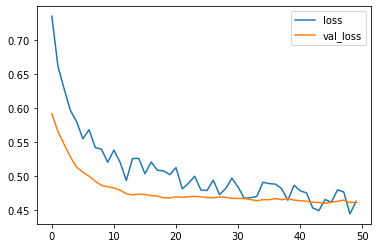

In [113]:
# 劃出 model.fit() training 和 validating 的 loss
import matplotlib.pyplot as plt
plt.plot(r2.history['loss'], label='loss')
plt.plot(r2.history['val_loss'], label='val_loss')
plt.legend()

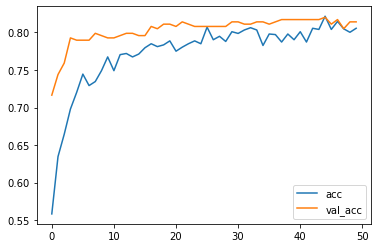

In [114]:
# 劃出準確性 accuracy 
plt.plot(r2.history['accuracy'], label='acc')
plt.plot(r2.history['val_accuracy'], label='val_acc')
plt.legend()

In [92]:
pred_test = model1.predict(X1_test)
pred_test = np.round(pred_test).flatten()
cm = confusion_matrix(y1_test, pred_test)
cm

NameError: name 'model1' is not defined

In [121]:
Xo = addenv_factor2[[       'operating_gross_rate', 
                            'current_rate', 
                            'quick_rate',  
                            'debt_rate',  
                            'receivables_turnover_rate', 
                            'cash_reinvest_rate',
                            'avg_director_rate', 
                            'avg_director_pledge_rate', 
                            'foreign_rate_bys', 
                            'over1000_rate_bys', 
                            'under400_rate_bys', 
                            'avg_board_bys',
                            'import_kgm_weight_2804', 
                            'import_kgm_weight_37079090',
                            'import_usd_value_2804',
                            'import_usd_value_37079090',
                            'avg_import_rate'
                    ]]

In [122]:
Xo_scaled = pd.DataFrame()
a, b = Xo.shape

for i in range(b):
    xo_new = mean_norm(Xo[Xo.columns[i]])
    Xo_scaled.insert(i,Xo.columns[i],xo_new)
Xo_scaled

,operating_gross_rate,current_rate,quick_rate,debt_rate,receivables_turnover_rate,cash_reinvest_rate,avg_director_rate,avg_director_pledge_rate,foreign_rate_bys,over1000_rate_bys,under400_rate_bys,avg_board_bys,import_kgm_weight_2804,import_kgm_weight_37079090,import_usd_value_2804,import_usd_value_37079090,avg_import_rate
0,0.310530,-0.553189,-0.513366,-0.818028,-0.161824,-0.205327,0.434003,-0.402937,-0.641917,0.840080,-0.635222,-0.310411,-0.148151,-0.695624,1.184422,-1.496335,0.561617
1,0.420361,-0.520781,-0.494960,-0.898471,-0.064074,-0.239816,0.434003,-0.402937,-0.641917,0.845653,-0.630684,-0.301024,0.206898,0.460159,1.533610,-0.823357,0.761148
2,0.272657,-0.507650,-0.496387,-0.926863,-0.379883,-0.225158,0.434003,-0.402937,-0.643402,0.854013,-0.650854,-0.298135,-1.145530,-1.910371,-0.236185,-1.500584,0.738125
3,0.085944,-0.500379,-0.482945,-0.912075,-0.284953,-0.168251,0.434003,-0.402937,-0.646868,0.845189,-0.659426,-0.290191,-0.358094,-0.959046,-0.280050,-1.020856,1.074696
4,-0.039793,-0.512620,-0.477102,-0.863573,-0.181562,0.017126,0.434003,-0.402937,-0.646868,0.844724,-0.662956,-0.282970,-1.408349,-0.835566,-1.816476,-0.224911,1.141572
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1634,0.022697,-0.102197,-0.251399,-0.372635,-0.285892,-0.357940,-0.083665,0.699086,1.941256,0.078366,-0.432514,-0.213645,0.511444,-0.569384,0.780981,0.332627,-0.047939
1635,-0.192042,-0.174049,-0.299321,-0.254929,-0.070653,0.204228,-0.083665,0.695634,1.671897,-0.116242,-0.092144,-0.398512,-0.590583,0.605388,-1.221414,0.987518,-0.291323
1636,-0.273468,-0.005312,-0.137752,-0.496257,0.109809,0.097313,-0.052838,1.141794,1.394616,-0.320605,0.256798,-0.465671,0.909084,0.772567,-0.869917,0.840153,-0.775898
1637,-0.256804,-0.127359,-0.166362,-0.352525,0.290272,0.617232,-0.042950,1.133164,1.470868,-0.347079,0.224021,-0.449784,2.132315,0.510076,0.134358,1.239036,-1.560866


In [123]:
#分割資料為 測試集 與 訓練集
from sklearn.model_selection import train_test_split
Xo_train, Xo_test, yo_train, yo_test = train_test_split(Xo_scaled, y1, test_size=0.2,random_state=1)
N, D = Xo_train.shape
print ("N:", N, "D:", D)

N: 1311 D: 17


In [124]:
# 建立TF模型 for 淨利
modelo = tf.keras.models.Sequential([
  tf.keras.layers.Input(shape=(D,)),
  tf.keras.layers.Dense(128, activation='relu'),
  tf.keras.layers.Dropout(0.6),
  tf.keras.layers.Dense(32, activation='relu'),
  tf.keras.layers.Dropout(0.4),
  tf.keras.layers.Dense(1, activation='sigmoid')
  ])

#編譯模型
lr = 0.0003
modelo.compile(tf.keras.optimizers.Adam(learning_rate = lr),
              loss='binary_crossentropy',
              metrics=['accuracy'])

In [125]:
modelo.summary()

Model: "sequential_14"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_42 (Dense)             (None, 128)               2304      
_________________________________________________________________
dropout_28 (Dropout)         (None, 128)               0         
_________________________________________________________________
dense_43 (Dense)             (None, 32)                4128      
_________________________________________________________________
dropout_29 (Dropout)         (None, 32)                0         
_________________________________________________________________
dense_44 (Dense)             (None, 1)                 33        
Total params: 6,465
Trainable params: 6,465
Non-trainable params: 0
_________________________________________________________________


In [126]:
# 訓練模型
ro = modelo.fit(Xo_train, y1_train, validation_data=(Xo_test, y1_test), epochs=100)

# 評估模型 - evaluate() returns loss and accuracy
print("Train score:", modelo.evaluate(Xo_train, y1_train))
print("Test score:", modelo.evaluate(Xo_test, y1_test))

Epoch 1/100
41/41 [==============================] - 0s 4ms/step - loss: 0.7415 - accuracy: 0.5172 - val_loss: 0.6618 - val_accuracy: 0.5976
Epoch 2/100
41/41 [==============================] - 0s 1ms/step - loss: 0.6939 - accuracy: 0.5606 - val_loss: 0.6420 - val_accuracy: 0.6402
Epoch 3/100
41/41 [==============================] - 0s 1ms/step - loss: 0.6863 - accuracy: 0.5912 - val_loss: 0.6292 - val_accuracy: 0.6524
Epoch 4/100
41/41 [==============================] - 0s 1ms/step - loss: 0.6704 - accuracy: 0.6064 - val_loss: 0.6186 - val_accuracy: 0.6707
Epoch 5/100
41/41 [==============================] - 0s 1ms/step - loss: 0.6443 - accuracy: 0.6232 - val_loss: 0.6093 - val_accuracy: 0.6829
Epoch 6/100
41/41 [==============================] - 0s 1ms/step - loss: 0.6334 - accuracy: 0.6270 - val_loss: 0.6019 - val_accuracy: 0.6951
Epoch 7/100
41/41 [==============================] - 0s 1ms/step - loss: 0.6368 - accuracy: 0.6354 - val_loss: 0.5948 - val_accuracy: 0.6829
Epoch 8/100
4

Epoch 59/100
41/41 [==============================] - 0s 2ms/step - loss: 0.4952 - accuracy: 0.7483 - val_loss: 0.5258 - val_accuracy: 0.7470
Epoch 60/100
41/41 [==============================] - 0s 2ms/step - loss: 0.5034 - accuracy: 0.7628 - val_loss: 0.5253 - val_accuracy: 0.7470
Epoch 61/100
41/41 [==============================] - 0s 2ms/step - loss: 0.5086 - accuracy: 0.7597 - val_loss: 0.5248 - val_accuracy: 0.7439
Epoch 62/100
41/41 [==============================] - 0s 2ms/step - loss: 0.5058 - accuracy: 0.7613 - val_loss: 0.5232 - val_accuracy: 0.7409
Epoch 63/100
41/41 [==============================] - 0s 2ms/step - loss: 0.5068 - accuracy: 0.7651 - val_loss: 0.5232 - val_accuracy: 0.7378
Epoch 64/100
41/41 [==============================] - 0s 2ms/step - loss: 0.5131 - accuracy: 0.7529 - val_loss: 0.5227 - val_accuracy: 0.7378
Epoch 65/100
41/41 [==============================] - 0s 2ms/step - loss: 0.5129 - accuracy: 0.7490 - val_loss: 0.5222 - val_accuracy: 0.7348
Epoch 

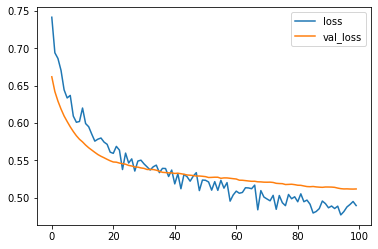

In [127]:
# 劃出 model.fit() training 和 validating 的 loss
import matplotlib.pyplot as plt
plt.plot(ro.history['loss'], label='loss')
plt.plot(ro.history['val_loss'], label='val_loss')
plt.legend()

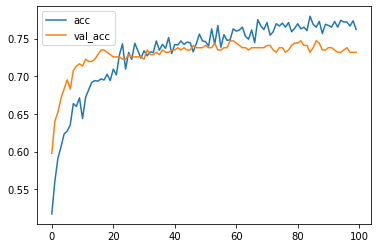

In [128]:
# 劃出準確性 accuracy 
plt.plot(ro.history['accuracy'], label='acc')
plt.plot(ro.history['val_accuracy'], label='val_acc')
plt.legend()

In [129]:
pred_test = modelo.predict(Xo_test)
pred_test = np.round(pred_test).flatten()
cm = confusion_matrix(y1_test, pred_test)
cm

array([[105,  43],
       [ 45, 135]], dtype=int64)